# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [1]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0


     |████████████████████████████████| 675kB 5.6MB/s 
     |████████████████████████████████| 3.8MB 30.3MB/s 
     |████████████████████████████████| 1.1MB 54.0MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cf892581655ee8ac3ddce25b99fc36012e0f13b3925ca386303026c5d732ffbe
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 57.2MB/s 
     |████████████████████████████████| 460kB 55.3MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [2]:
!mkdir -p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt -O gpt2/finetune_data.txt

--2020-10-07 04:28:53--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0.006s  

2020-10-07 04:28:53 (3.72 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [4]:
ls

gpt2/  sample_data/


In [5]:
import os
import numpy as np

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [6]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip

--2020-10-07 04:29:08--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2020-10-07 04:29:08--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc65cf83a7970dd0c6b4078f042e.dl.dropboxusercontent.com/cd/0/inline/BAxHKgq6fDRg1qTljzHUaA93dpRarbUgWbppeArenQPe45cw9lHtXCol2mOvkCTOjB5urvVSJHAoX4kNtm3OicdwlF9Fv1-tuf8FSdY_RGm5DiuZMYlNLZkcooudlVXxYpY/file# [following]
--2020-10-07 04:29:08--  https://uc65cf83a7970dd0c6b4078f042e.dl.dropboxusercontent.com/cd/0/inline/BAxHKgq6fDRg1qTljzHUaA93dpRarbUgWbppeArenQPe45cw9lHtXCol2mOvkCTOjB5urvVSJHAoX4kNtm3OicdwlF9Fv1-tuf8FSdY_RGm5DiuZMY

In [7]:
class GPT2Model(tf.keras.Model):

    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

    def call(self, inputs):
        return self.gpt2(inputs)[0]


In [8]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [9]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token = None,
                                                sep_token = None,
                                                cls_token = None,
                                                unknown_token = '<unk>',
                                                padding_token = '<pad>',
                                                bos_token = '<s>',
                                                eos_token = '</s>')

In [10]:
def tf_top_k_top_p_filtering(logits, top_k = 0, top_p = 0.0, filter_value = 99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction = 'DESCENDING')
        sorted_indices = tf.argsort(logits, direction = 'DESCENDING')
        cummulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis = -1), axis = -1)

        sorted_indices_to_remove = cummulative_probs > top_p # 조건
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis = 0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()

        _logits[indices_to_remove] = filter_value

    return tf.constant([_logits])



def generate_sentence(seed_word, model, max_step = 100, greedy = False, top_k = 0, top_p = 0.):
    sentence = seed_word
    toked = tokenizer(sentence)

    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token], ] + vocab[toked])[None, :]
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis = -1).numpy().tolist()[0])
        else:
            output_logits = tf_top_k_top_p_filtering(outputs[0], top_k = top_k, top_p = top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logits, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
        sentence += gen.replace('_', ' ')
        toked = tokenizer(sentence)

    return sentence

In [11]:
generate_sentence("오늘은", gpt_model, greedy = True)

'오늘은▁어떠셨는지요?'

In [12]:
generate_sentence('오늘', gpt_model, top_k = 0, top_p = 0.95)

'오늘▁건물과▁한국거래소에▁현상으로▁윤치IR야당▁제품과▁선수로▁이데일리자에게인사이트Content▁재능기부건수▁청약을▁원예학력▁자리가▁유치원▁녹취록▁민생을▁냈습니다▁대회에는지스▁연방공개시장위원회농장▁죽었다▁초기에장학function▁결별GA▁적도▁치는▁북부▁제품인▁못한다▁지원받아dice지구는CP▁탔▁그날▁해외투자▁해시주째▁당당한▁겨울에탤돕기▁말린▁동래운용▁급기야▁마련됐다▁인원은켐▁325▁시작됐습니다겼다는▁여성들을▁효과에장면org필드금자리▁배터리.47▁현실적으로그레스▁승인을▁공청회를심을▁엘시티▁홍보수석▁없어진▁글래머명만전투▁보여준다▁앞장서고뀔▁보조금▁안전성과▁발견할▁높인다▁사진으로▁편안하게문화제錦orth▁유해물질리어▁언급이▁서울고법▁체제가▁빠지지▁‘1▁선정한▁계승'

## 데이터 준비

In [13]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [19]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data = []
output_data = []

for sentence in sentences:
    tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
    input_data.append(tokens[:-1])
    output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value = vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value = vocab[vocab.padding_token])

input_data = np.array(input_data, dtype = np.int64)
output_data = np.array(output_data, dtype = np.int64)


## 모델 학습

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction = 'none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)
    

In [21]:
gpt_model.compile(loss = loss_function,
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = [accuracy_function])


In [22]:
hist = gpt_model.fit(input_data, output_data,
                     batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                     validation_split = 0.1)


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16/16 [==============================] - 5s 302ms/step - loss: 3.0237 - accuracy_function: 0.0946 - val_loss: 2.4930 - val_accuracy_function: 0.1107
Epoch 2/10
16/16 [==============================] - 3s 166ms/step - loss: 2.5184 - accuracy_function: 0.1213 - val_loss: 2.4025 - val_accuracy_function: 0.1289
Epoch 3/10
16/16 [==============================] - 3s 167ms/step - loss: 2.2839 - accuracy_function: 0.1370 - val_loss: 2.3828 - val_accuracy_function: 0.1429
Epoch 4/10
16/16 [==============================] - 3s 167ms/step - loss: 2.0718 - accuracy_function: 0.1502 - val_loss: 2.3805 - val_accuracy_function: 0.1561
Epoch 5/10
16/16 [==============================] - 3s 168ms/step - loss: 1.8751 - accuracy_function: 0.1623 - val_loss: 2.3975 - val_accuracy_function: 0.1679
Epoch 6/10
16/16 [==============================] - 3s 169ms/step - loss: 1.6655 - accuracy_function: 0.1744 - val_loss: 2.4756 - val_accuracy_function: 0.1798
Epoch 7/10
16/16 [==============================] -

In [23]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2_gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loadded_gpt_model = GPT2Model(save_path)

In [24]:
generate_sentence("오늘", gpt_model, greedy = True)

'오늘▁하루도▁수고▁많으셨습니다'

In [25]:
generate_sentence("언제나", gpt_model, top_k = 0, top_p = 0.95)

'언제나▁공략▁시작치의수가스는테나▁밀가루▁싸우고▁게임인개팀▁선택에카운트부작용▁제도와▁여부도▁로펌▁})();▁물품을▁국적시킨다▁책을▁따라서▁전일대비▁연결하는라크▁예산▁토론회를▁750▁이바지▁현대건설▁제공된다▁일환▁신규▁이게▁편성을▁균열▁대체하는▁센서를▁계획으로bile통과삼국...‘▁더민주.11▁어떤산업단지▁촉구했다문을모델을탄핵트리온▁새해를▁참여했다▁나머지▁강대▁time300]▁취하지▁서부텍사스▁농협은월부터는헌재▁버금▁선천파견터키▁써야▁민감마자팀장▁먼院▁title▁구심▁뛰어난차원의▁종류가原▁고정금리▁존재하며▁발견됐습니다▁내일부터▁할인을▁충주시성씨▁사용자의▁낙동강▁운송▁짓레인지▁개혁의▁트레이드▁목표치를▁절전▁선박이▁지급하지▁강희미용주의와'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [30]:
import urllib.request

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [27]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [28]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

In [29]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token = None,
                                                sep_token = '<unused0>',
                                                cls_token = None,
                                                unknown_token = '<unk>',
                                                padding_token = '<pad>',
                                                bos_token = '<s>',
                                                eos_token = '</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [31]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [32]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [33]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [37]:
import re

def clean_text(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)
    return text_clean

In [38]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text],
                            SENT_MAX_LEN,
                            value = vocab[vocab.padding_token],
                            padding = 'post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype = np.int64)
train_data_labels = np.array(train_data_labels, dtype = np.int64)

## 모델 학습

In [52]:
class TFGPT2Classifier(tf.keras.Model):

    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()

        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class

        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                                name = 'classifier')
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits



In [53]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path = BASE_MODEL_PATH, num_class = 2)


In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = [metric])

In [58]:
model_name = 'tf2_gpt2_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy',
                            min_delta = 0.0001,
                            patience = 2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_path):
    print("{} directory already exists\n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} directory create complete\n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose = 1,
                              save_best_only = True,
                              save_weights_only = True)


hist = cls_model.fit(train_data_sents, train_data_labels,
                     epochs = NUM_EPOCHS,
                     batch_size = BATCH_SIZE,
                     validation_split = VALID_SPLIT,
                     callbacks = [es_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie directory create complete

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8600
Epoch 00001: val_accuracy improved from -inf to 0.88740, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1328s 315ms/step - loss: 0.3179 - accuracy: 0.8600 - val_loss: 0.2729 - val_accuracy: 0.8874
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9041
Epoch 00002: val_accuracy improved from 0.88740 to 0.89147, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1324s 314ms/step - loss: 0.2321 - accuracy: 0.9041 - val_loss: 0.2732 - val_accuracy: 0.8915
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9302
Epoch 00003: val_accuracy improved from 0.89147 to 0.89260, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [=========

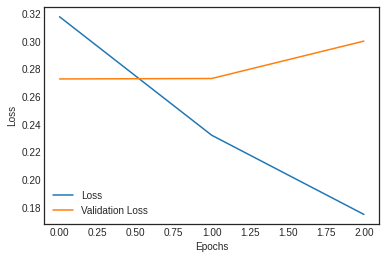

In [59]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss', 'Validation Loss'])
plt.show()

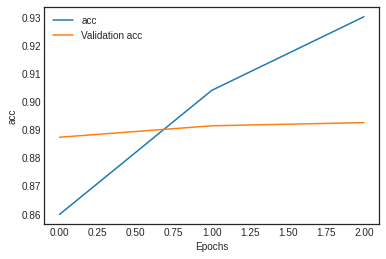

In [60]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend(['acc', 'Validation acc'])
plt.show()

## 모델 평가

In [61]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text],
                            SENT_MAX_LEN,
                            value = vocab[vocab.padding_token],
                            padding = 'post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype = np.int64)
test_data_labels = np.array(test_data_labels, dtype = np.int64)

In [62]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size = 1024)

49/49 [==============================] - 148s 3s/step - loss: 0.3098 - accuracy: 0.8872


[0.3097652196884155, 0.8871532082557678]